In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(zellkonverter)
library(loomR)
library(Seurat)
library(SeuratDisk)
library(data.table)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
adata_loom <- connect(filename = "/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_Endo_SMC_scvi_adata_diet.loom", mode = "r+",skip.validate = TRUE)

matrix=adata_loom[["matrix"]][,]
matrix=t(matrix)
dim(matrix)

gene = adata_loom$row.attrs$var_names[]
barcode = adata_loom$col.attrs$obs_names[]
meta_data = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_Endo_SMC_scvi_adata_diet_obs.csv',row.names = 1) # 这个直接给个dataframe吧
meta_feature = read.csv('/public/LiuTL/Rstudio/skeletal_muscle/moli_v2/data/ICM_Endo_SMC_scvi_adata_diet_var.csv',row.names = 1)

colnames(matrix)= barcode
row.names(matrix)= gene
x_scvi = adata_loom$col.attrs$X_scVI[,]
x_umap = adata_loom$col.attrs$X_umap[,]


seurat_object_MuSC= CreateSeuratObject(counts = matrix,meta.data = meta_data,
                                       project = 'musc_loom',
                                       min.cells = 0, 
                                       min.features = 0)

seurat_object_MuSC@assays[["RNA"]]@meta.features <- meta_feature
# seurat_object_MuSC@reductions[["scVI"]]@cell.embeddings <- x_scvi

x_scvi = t(x_scvi)
x_umap = t(x_umap)
rownames(x_scvi) = barcode
rownames(x_umap) = barcode
colnames(x_scvi) = c("scVI_1","scVI_2","scVI_3","scVI_4","scVI_5","scVI_6","scVI_7","scVI_8","scVI_9","scVI_10","scVI_11","scVI_12","scVI_13","scVI_14","scVI_15","scVI_16","scVI_17","scVI_18","scVI_19","scVI_20","scVI_21","scVI_22","scVI_23","scVI_24","scVI_25","scVI_26","scVI_27","scVI_28","scVI_29","scVI_30")
colnames(x_umap) = c('umap_1','umap_2')

Warning message in initialize(...):
“Skipping validation step, some fields are not populated”


[1] 33538 19317

Warning message:
“The following arguments are not used: row.names”


In [3]:
sce1 = as.SingleCellExperiment(seurat_object_MuSC)

sce1@int_colData@listData[["reducedDims"]]@listData[["SCVI"]] = x_scvi
sce1@int_colData@listData[["reducedDims"]]@listData[["UMAP"]] = x_umap

In [4]:
milo_obj = Milo(sce1)
milo_obj = buildGraph(milo_obj, k = 40, d = 30,reduced.dim = "SCVI")
milo_obj = makeNhoods(milo_obj, prop = 0.1, k = 40, d=30, refined = TRUE, reduced_dims = "SCVI")
milo_obj = countCells(milo_obj, meta.data = as.data.frame(colData(milo_obj)), sample="SampleID")
head(nhoodCounts(milo_obj))
summary(rowSums(nhoodCounts(milo_obj)))
sample_order = colnames(nhoodCounts(milo_obj))

exp_design <- data.frame(colData(milo_obj))[,c("SampleID","DonorID", "X10X_version", "Sex", "Age_bin")]
exp_design = distinct(exp_design)
rownames(exp_design) = exp_design$SampleID
exp_design = exp_design[sample_order,]
exp_design

milo_obj = calcNhoodDistance(milo_obj, d=30, reduced.dim = "SCVI")
da_results = testNhoods(milo_obj, design = ~ X10X_version+ Sex + Age_bin, design.df = exp_design)
head(da_results)

Constructing kNN graph with k:40

Checking valid object

Checking meta.data validity

Counting cells in neighbourhoods

   [[ suppressing 21 column names ‘mus_SNuc7468112’, ‘mus_SNuc7511880’, ‘5386STDY7600838’ ... ]]



6 x 21 sparse Matrix of class "dgCMatrix"
                                                 
1 3 2 6 3  7 16  5 7 18 23 11 . . . . 2 . 1 . . .
2 3 4 7 4 10  8  9 9  . 30 21 . . 2 3 . 2 . . 1 3
3 . . . . 51 37  . 1  .  .  . . . . . . 1 . . . .
4 5 . . 2  .  . 11 6  . 10 13 . 1 1 2 1 . . . . .
5 9 2 4 9  3  3  4 9  .  6 11 . . . 1 1 1 . . . .
6 1 . . .  3  4  4 4  6 23 28 1 2 2 3 4 . 3 4 . .

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  42.00   62.00   79.00   87.05  104.00  251.00 

,SampleID,DonorID,X10X_version,Sex,Age_bin
,<chr>,<chr>,<chr>,<chr>,<chr>
mus_SNuc7468112,mus_SNuc7468112,339C,3'v2,F,2Aged
mus_SNuc7511880,mus_SNuc7511880,343B,3'v2,F,2Aged
5386STDY7600838,5386STDY7600838,362C,3'v2,M,2Aged
5386STDY7600839,5386STDY7600839,362C,3'v2,M,2Aged
5386STDY7645353,5386STDY7645353,367C,3'v2,M,2Aged
5386STDY7645354,5386STDY7645354,367C,3'v2,M,2Aged
5386STDY7835292,5386STDY7835292,411C,3'v2,M,1Young
5386STDY7835293,5386STDY7835293,411C,3'v2,M,1Young
5386STDY8047212,5386STDY8047212,464C,3'v2,M,1Young


as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854


In [5]:
save.image('./write/human_SKM_v2_EnSMC_moli_v3_r_2.RData')

In [2]:
# load('./write/human_SKM_v2_EnSMC_moli_v3_r.RData')

In [6]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
59,5.968348,9.99044,34.17114,5.111884e-09,2.615045e-07,59,2.41739e-07
115,6.356362,10.21582,34.50756,4.301457e-09,2.615045e-07,115,2.41739e-07
127,6.576968,10.34611,35.96251,2.040000e-09,2.615045e-07,127,2.41739e-07
304,6.066196,10.04518,34.29036,4.808520e-09,2.615045e-07,304,2.41739e-07
325,6.538146,10.32290,35.81955,2.195076e-09,2.615045e-07,325,2.41739e-07
338,6.139748,10.08716,34.33186,4.707215e-09,2.615045e-07,338,2.41739e-07


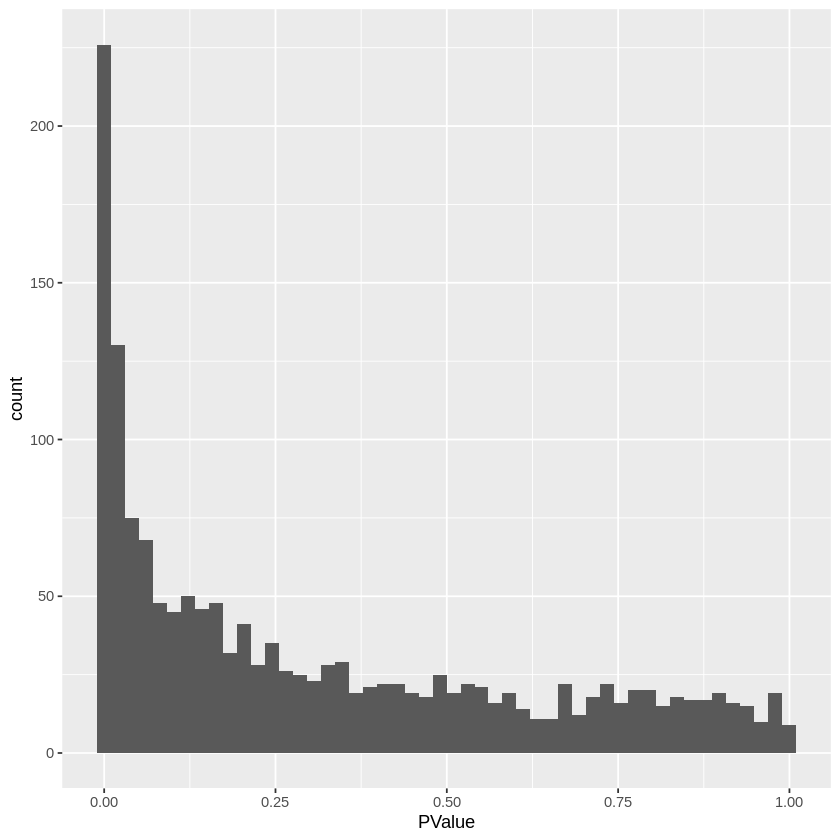

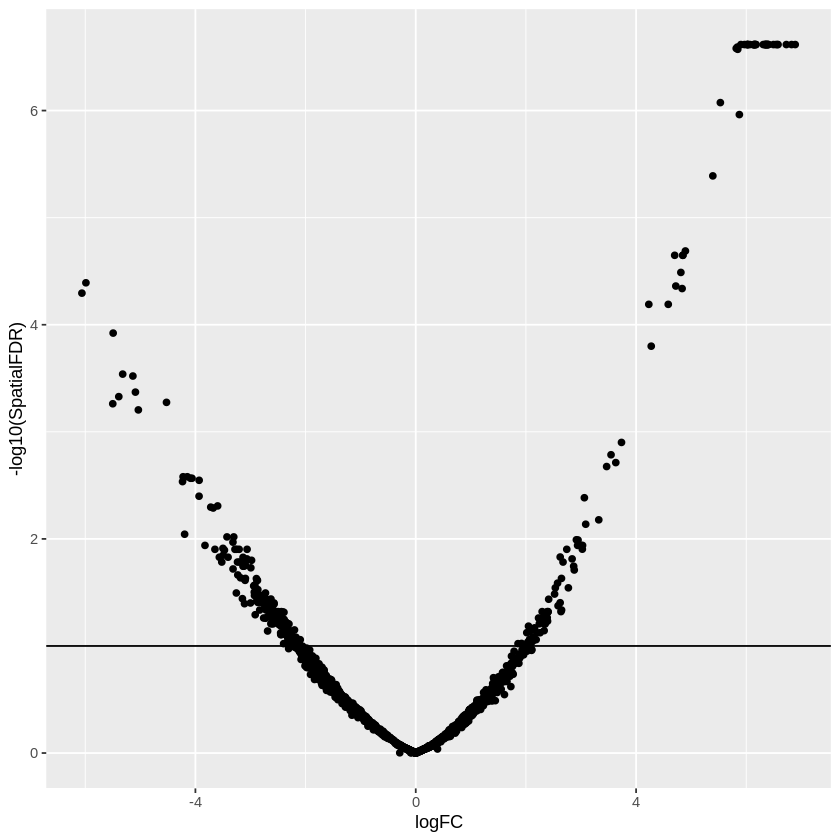

In [7]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + geom_point() +  geom_hline(yintercept = 1) 

In [8]:
milo_obj = buildNhoodGraph(milo_obj)
colData(milo_obj)

DataFrame with 19317 rows and 56 columns
                                    orig.ident nCount_RNA nFeature_RNA
                                      <factor>  <numeric>    <integer>
mus_SNuc7468112-GTGTGCGCAATGGACG-0   musc_loom      27233         4442
mus_SNuc7468112-CACAGGCGTTGCCTCT-0   musc_loom      23438         4906
mus_SNuc7468112-TCAGCAAAGCTGCGAA-0   musc_loom      22903         4106
mus_SNuc7468112-GCATACACAGCTTCGG-0   musc_loom      22678         4402
mus_SNuc7468112-GATTCAGAGTGTACGG-0   musc_loom      22230         4242
...                                        ...        ...          ...
WS_A_SKM10490128-TCTACATGTAGCTGTT-1  musc_loom       1422          818
WS_A_SKM10490128-ATCGCCTCACAGTATC-1  musc_loom       1392          721
WS_A_SKM10490128-TCTGTCGGTCGTGATT-1  musc_loom       1258          750
WS_A_SKM10490128-ACTATTCAGGTACAGC-1  musc_loom       1081          595
WS_A_SKM10490128-ATATCCTCATACAGAA-1  musc_loom        871          520
                                    

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



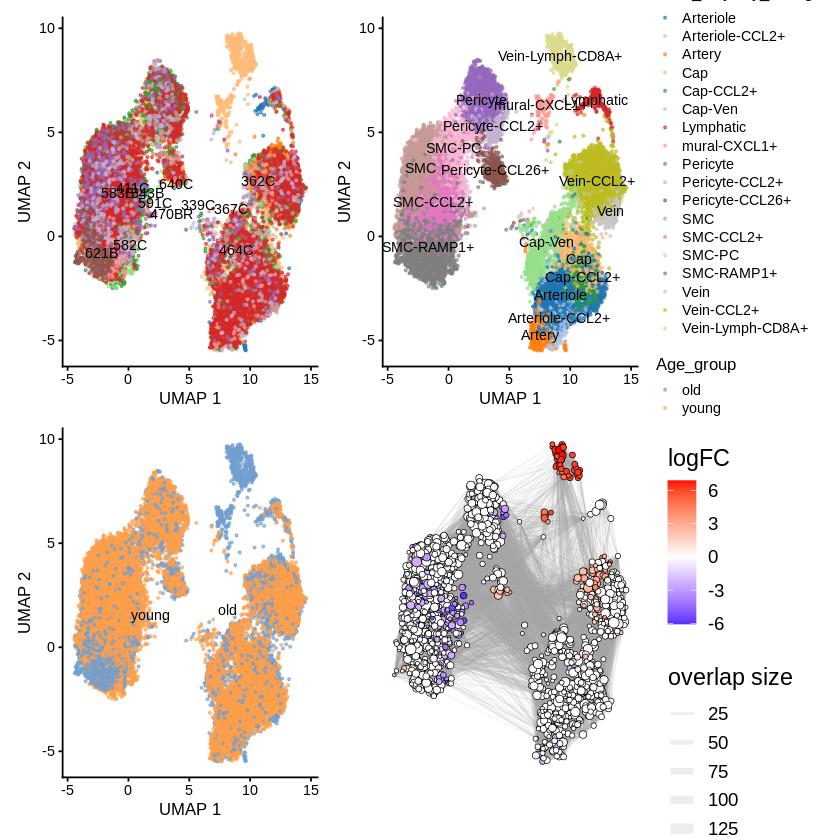

In [9]:
## Plot single-cell UMAP
umap_pl1 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", text_by = "DonorID", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl2 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="fine2_majority_voting", text_by = "fine2_majority_voting", text_size = 3, point_size=0.5) +  guides(fill="none")
umap_pl3 <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="Age_group", text_by = "Age_group", text_size = 3, point_size=0.5) +  guides(fill="none")

# str(milo_obj)
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(milo_obj, da_results, layout="UMAP",alpha=0.1) + scale_fill_gradient2(name = "logFC", low = "blue", high = "red") 

nh_plt_comb = umap_pl1+umap_pl2+umap_pl3 + nh_graph_pl + plot_layout(guides="collect")
nh_plt_comb

In [10]:
ggsave(filename = "./figure/human_SKM_v2_EnSMC_moli_v3_r_1.png", plot = nh_plt_comb, width = 10, height = 10)

In [11]:
da_results <- annotateNhoods(milo_obj, da_results, coldata_col = "fine2_majority_voting")
head(da_results)

Converting fine2_majority_voting to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264,Arteriole,0.6538462
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046,SMC-PC,0.4741379
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375,mural-CXCL1+,0.9666667
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703,SMC,0.6538462
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726,Pericyte-CCL2+,0.7619048
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854,SMC-RAMP1+,0.6086957


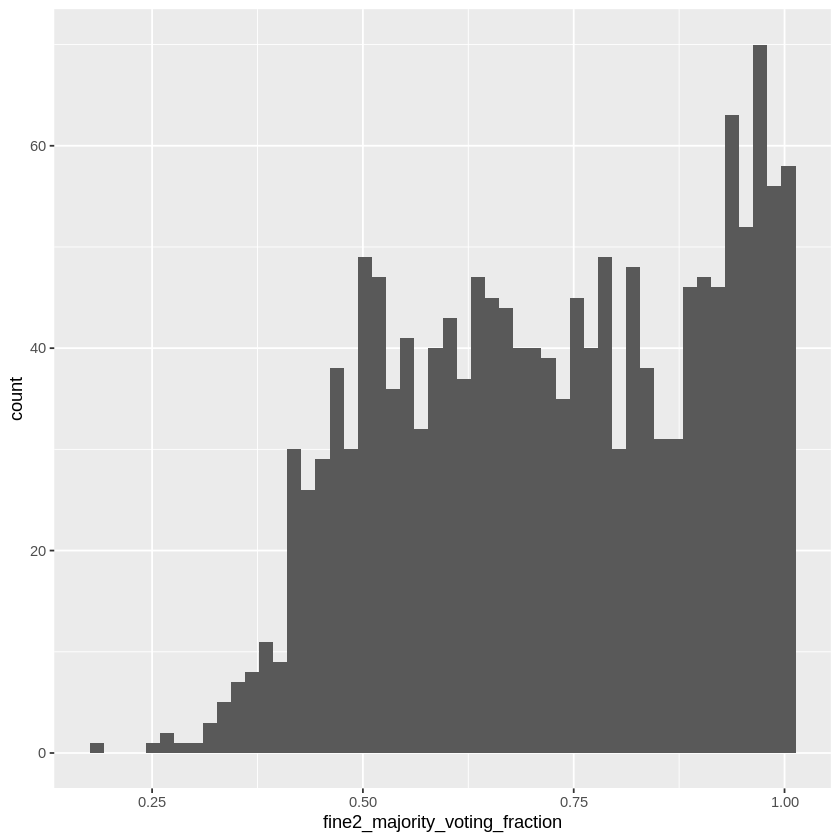

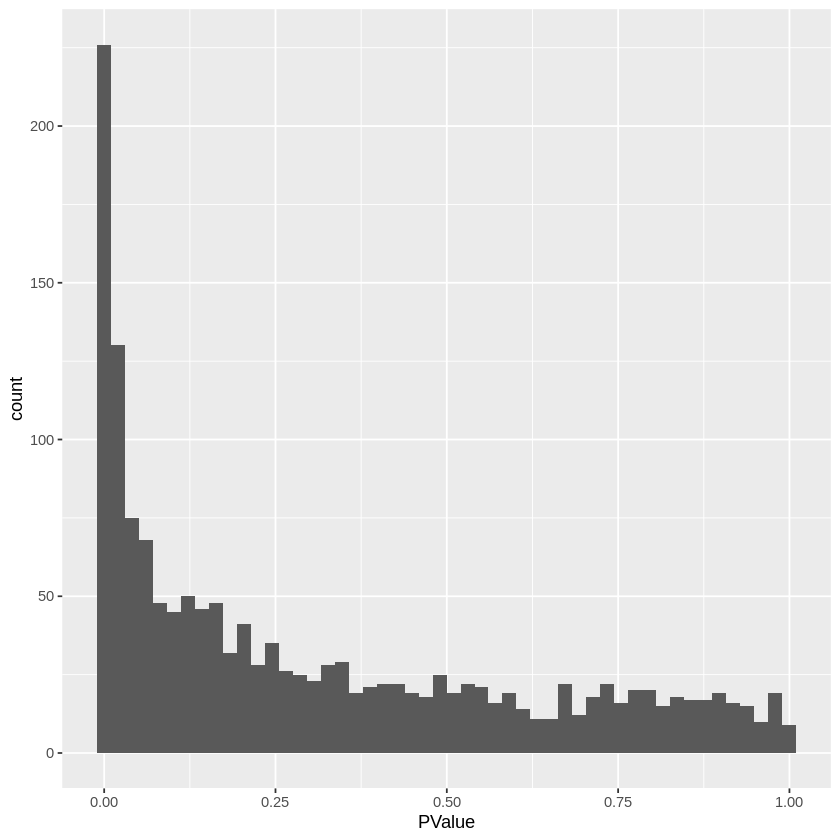

In [12]:
ggplot(da_results, aes(fine2_majority_voting_fraction)) + geom_histogram(bins=50)
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

In [13]:
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264,Arteriole,0.6538462
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046,SMC-PC,0.4741379
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375,mural-CXCL1+,0.9666667
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703,SMC,0.6538462
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726,Pericyte-CCL2+,0.7619048
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854,SMC-RAMP1+,0.6086957


In [35]:
da_results$fine2_majority_voting_clean <- ifelse(da_results$fine2_majority_voting_fraction < 0.7, "Mixed", da_results$fine2_majority_voting)

In [36]:
table(da_results$fine2_majority_voting_clean)


       Arteriole  Arteriole-CCL2+           Artery              Cap 
              72                1               14               34 
       Cap-CCL2+          Cap-Ven        Lymphatic            Mixed 
              16               62                6              712 
    mural-CXCL1+         Pericyte   Pericyte-CCL2+  Pericyte-CCL26+ 
               5              120               12               20 
             SMC        SMC-CCL2+           SMC-PC       SMC-RAMP1+ 
              87               55               19              124 
            Vein       Vein-CCL2+ Vein-Lymph-CD8A+ 
               8              163               37 

In [37]:
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264,Arteriole,0.6538462,Mixed
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046,SMC-PC,0.4741379,Mixed
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375,mural-CXCL1+,0.9666667,mural-CXCL1+
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703,SMC,0.6538462,Mixed
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726,Pericyte-CCL2+,0.7619048,Pericyte-CCL2+
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854,SMC-RAMP1+,0.6086957,Mixed


In [38]:
cell_type = c("Artery",'Arteriole-CCL2+',"Arteriole","Cap","Cap-CCL2+","Cap-Ven","Vein","Vein-CCL2+","Vein-Lymph-CD8A+","Lymphatic","mural-CXCL1+","SMC","SMC-RAMP1+","SMC-CCL2+","SMC-PC","Pericyte","Pericyte-CCL2+","Pericyte-CCL26+")

In [40]:
da_results$fine2_majority_voting_clean <- factor(da_results$fine2_majority_voting_clean, levels=cell_type, ordered=TRUE)

In [41]:
library(ggbeeswarm)

In [42]:
da_results_clean1 = da_results[da_results$fine2_majority_voting_clean %in% cell_type,]
da_results_clean2 = da_results[da_results$fine2_majority_voting_clean %in% c("Artery",'Arteriole-CCL2+',"Arteriole","Cap","Cap-CCL2+","Cap-Ven","Vein","Vein-CCL2+","Lymphatic","SMC","SMC-RAMP1+","SMC-CCL2+","SMC-PC","Pericyte","Pericyte-CCL2+","Pericyte-CCL26+"),]

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



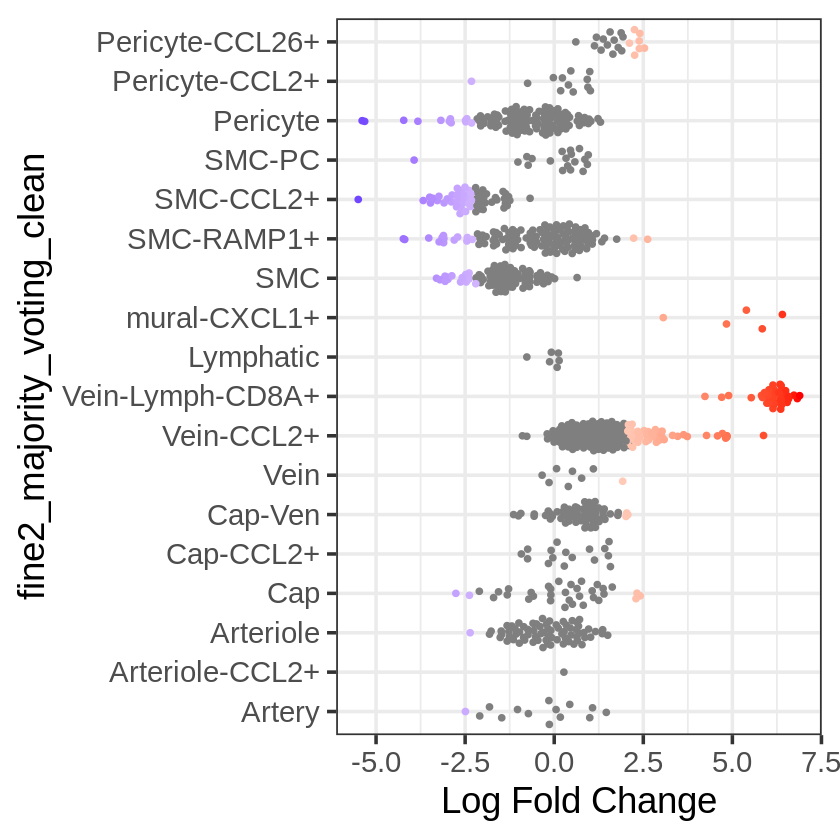

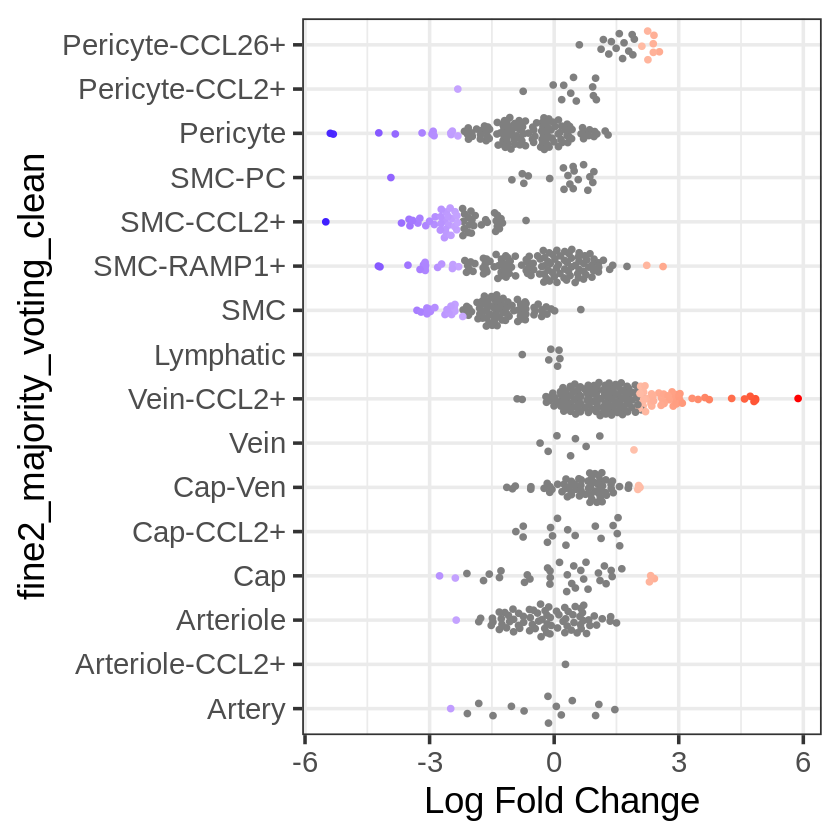

In [43]:
difab_plot = plotDAbeeswarm(da_results_clean1, group.by ="fine2_majority_voting_clean") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot
difab_plot_rm = plotDAbeeswarm(da_results_clean2, group.by ="fine2_majority_voting_clean") +scale_color_gradient2(low = ("blue"), high = ("red")) 
difab_plot_rm

Code to remove Donor specific neughbourhoods

In [39]:
da_results2 <- annotateNhoods(milo_obj, da_results, coldata_col = "DonorID")
head(da_results2)

Converting DonorID to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264,Arteriole,0.6538462,Mixed,470BR,0.3269231
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046,SMC-PC,0.4741379,Mixed,470BR,0.4396552
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375,mural-CXCL1+,0.9666667,mural-CXCL1+,367C,0.9777778
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703,SMC,0.6538462,Mixed,470BR,0.4423077
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726,Pericyte-CCL2+,0.7619048,Pericyte-CCL2+,470BR,0.2698413
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854,SMC-RAMP1+,0.6086957,Mixed,470BR,0.5543478


In [44]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264,Arteriole,0.6538462,Mixed,470BR,0.3269231
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046,SMC-PC,0.4741379,Mixed,470BR,0.4396552
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375,mural-CXCL1+,0.9666667,mural-CXCL1+,367C,0.9777778
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703,SMC,0.6538462,Mixed,470BR,0.4423077
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726,Pericyte-CCL2+,0.7619048,Pericyte-CCL2+,470BR,0.2698413
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854,SMC-RAMP1+,0.6086957,Mixed,470BR,0.5543478


Plot distribution of max donor percentage across all neighbourhoods

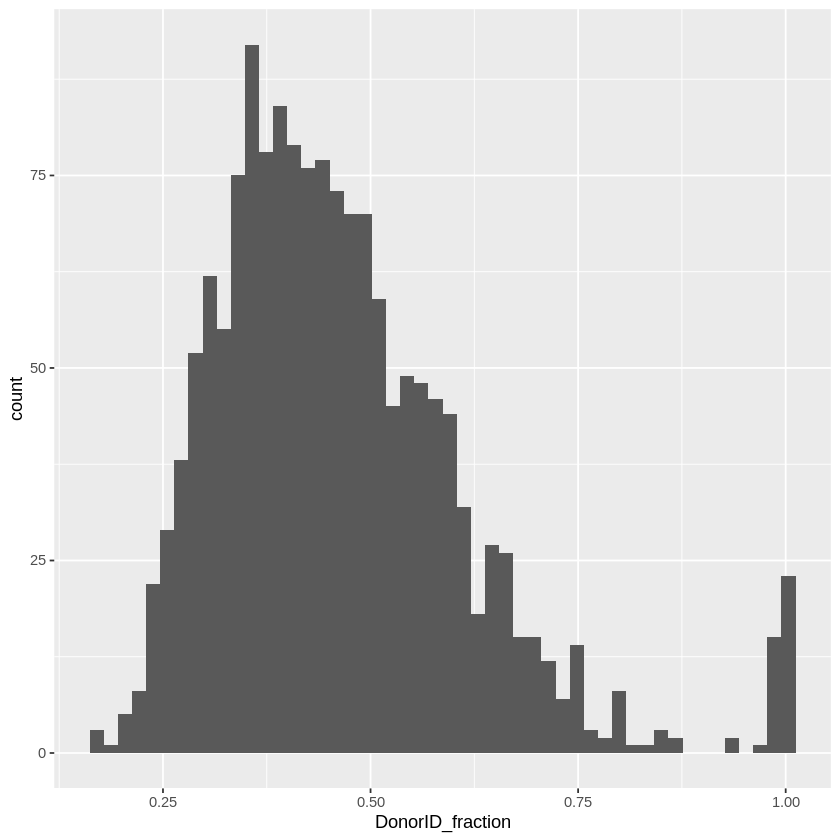

In [45]:
ggplot(da_results2, aes(DonorID_fraction)) + geom_histogram(bins=50)

Plot distribution of max donor percentage across significant neighbourhoods

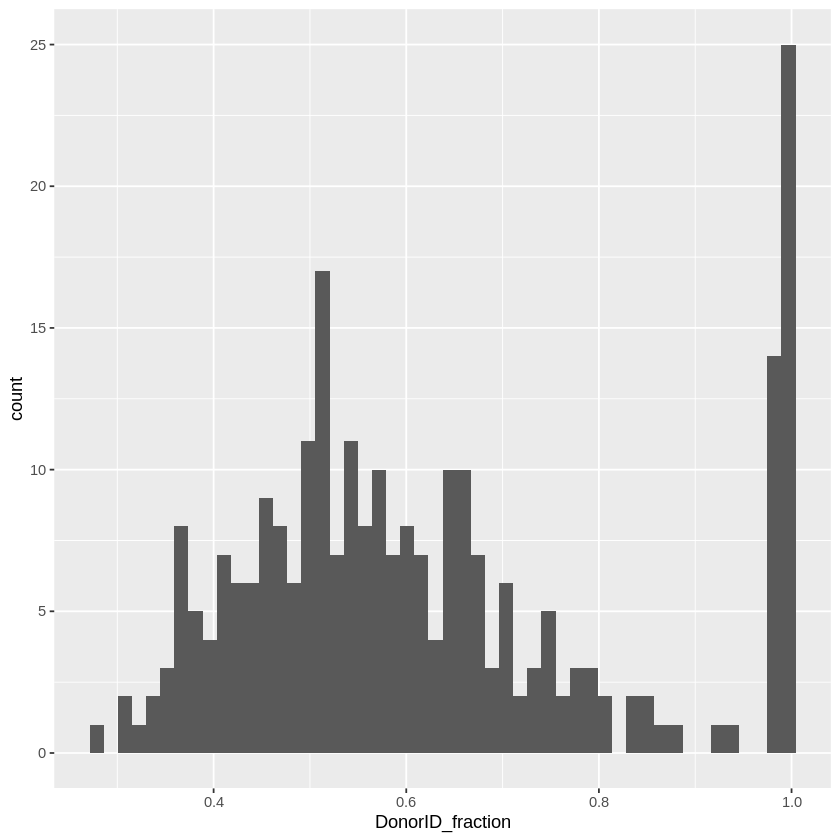

In [46]:
ggplot(da_results2[da_results2$SpatialFDR<0.1,], aes(DonorID_fraction)) + geom_histogram(bins=50)

Do not display neighbourhoods that have contain more than 90 % cells from one donor on the milo beeswarm plot

In [47]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264,Arteriole,0.6538462,Mixed,470BR,0.3269231
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046,SMC-PC,0.4741379,Mixed,470BR,0.4396552
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375,mural-CXCL1+,0.9666667,mural-CXCL1+,367C,0.9777778
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703,SMC,0.6538462,Mixed,470BR,0.4423077
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726,Pericyte-CCL2+,0.7619048,Pericyte-CCL2+,470BR,0.2698413
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854,SMC-RAMP1+,0.6086957,Mixed,470BR,0.5543478


In [48]:
da_results2$annotation_level1_clean = da_results2$fine2_majority_voting_clean

In [49]:
da_results2$annotation_level1_clean2 <- ifelse(da_results2$DonorID_fraction > 0.9, "Donor-specific", da_results2$annotation_level1_clean)

In [50]:
head(da_results2)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,fine2_majority_voting,fine2_majority_voting_fraction,fine2_majority_voting_clean,DonorID,DonorID_fraction,annotation_level1_clean,annotation_level1_clean2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,-0.3234367,10.585443,0.15039971,6.981568e-01,8.319480e-01,1,0.8351545264,Arteriole,0.6538462,Mixed,470BR,0.3269231,Mixed,Mixed
2,-0.3556865,10.604376,0.20295302,6.523514e-01,8.004970e-01,2,0.8035044046,SMC-PC,0.4741379,Mixed,470BR,0.4396552,Mixed,Mixed
3,4.8355369,10.276924,23.28371959,1.406279e-06,4.790522e-05,3,0.0000459375,mural-CXCL1+,0.9666667,mural-CXCL1+,367C,0.9777778,mural-CXCL1+,Donor-specific
4,-2.8805642,9.879047,8.94607090,2.783213e-03,3.208640e-02,4,0.0327698703,SMC,0.6538462,Mixed,470BR,0.4423077,Mixed,Mixed
5,0.2297382,10.139034,0.07334301,7.865322e-01,8.839012e-01,5,0.8857889726,Pericyte-CCL2+,0.7619048,Pericyte-CCL2+,470BR,0.2698413,Pericyte-CCL2+,Pericyte-CCL2+
6,-1.0904232,10.490177,1.90058711,1.680242e-01,3.667046e-01,6,0.3711295854,SMC-RAMP1+,0.6086957,Mixed,470BR,0.5543478,Mixed,Mixed


In [51]:
table(da_results2$annotation_level1_clean2)


      Arteriole Arteriole-CCL2+          Artery             Cap       Cap-CCL2+ 
             72               1              14              34              16 
        Cap-Ven  Donor-specific       Lymphatic           Mixed    mural-CXCL1+ 
             62              41               6             712               1 
       Pericyte  Pericyte-CCL2+ Pericyte-CCL26+             SMC       SMC-CCL2+ 
            120              12              20              87              55 
         SMC-PC      SMC-RAMP1+            Vein      Vein-CCL2+ 
             19             124               8             163 

In [52]:
da_results2$annotation_level1_clean2 = factor(da_results2$annotation_level1_clean2, levels = 
                                             c("Artery",'Arteriole-CCL2+',"Arteriole","Cap","Cap-CCL2+","Cap-Ven","Vein","Vein-CCL2+","Lymphatic","mural-CXCL1+","SMC","SMC-RAMP1+","SMC-CCL2+","SMC-PC","Pericyte","Pericyte-CCL2+","Pericyte-CCL26+",'Vein-Lymph-CD8A+', 'Mixed',"Donor-specific"))

In [53]:
figures_path = './figure/'
tables_path = './table/'

In [54]:
da_results2_clean1 = da_results2[da_results2$annotation_level1_clean2 %in% c("Artery",'Arteriole-CCL2+',"Arteriole","Cap","Cap-CCL2+","Cap-Ven","Vein","Vein-CCL2+","Lymphatic","SMC","SMC-RAMP1+","SMC-CCL2+","SMC-PC","Pericyte","Pericyte-CCL2+","Pericyte-CCL26+"),]

In [55]:
table(da_results2$annotation_level1_clean2)


          Artery  Arteriole-CCL2+        Arteriole              Cap 
              14                1               72               34 
       Cap-CCL2+          Cap-Ven             Vein       Vein-CCL2+ 
              16               62                8              163 
       Lymphatic     mural-CXCL1+              SMC       SMC-RAMP1+ 
               6                1               87              124 
       SMC-CCL2+           SMC-PC         Pericyte   Pericyte-CCL2+ 
              55               19              120               12 
 Pericyte-CCL26+ Vein-Lymph-CD8A+            Mixed   Donor-specific 
              20                0              712               41 

In [56]:
table(da_results2_clean1$annotation_level1_clean2)


          Artery  Arteriole-CCL2+        Arteriole              Cap 
              14                1               72               34 
       Cap-CCL2+          Cap-Ven             Vein       Vein-CCL2+ 
              16               62                8              163 
       Lymphatic     mural-CXCL1+              SMC       SMC-RAMP1+ 
               6                0               87              124 
       SMC-CCL2+           SMC-PC         Pericyte   Pericyte-CCL2+ 
              55               19              120               12 
 Pericyte-CCL26+ Vein-Lymph-CD8A+            Mixed   Donor-specific 
              20                0                0                0 

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



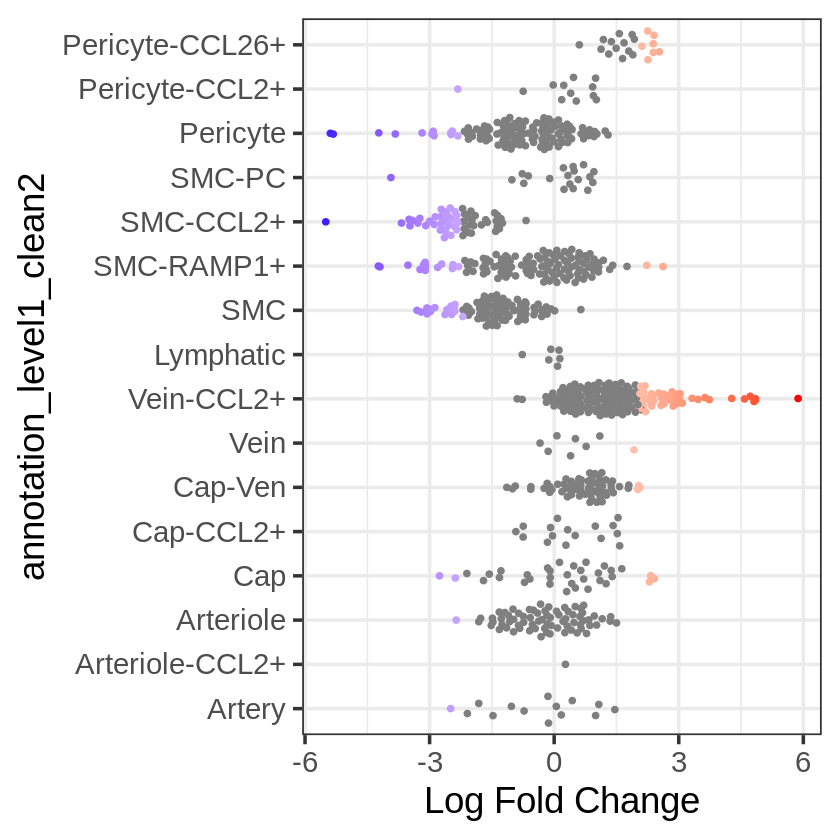

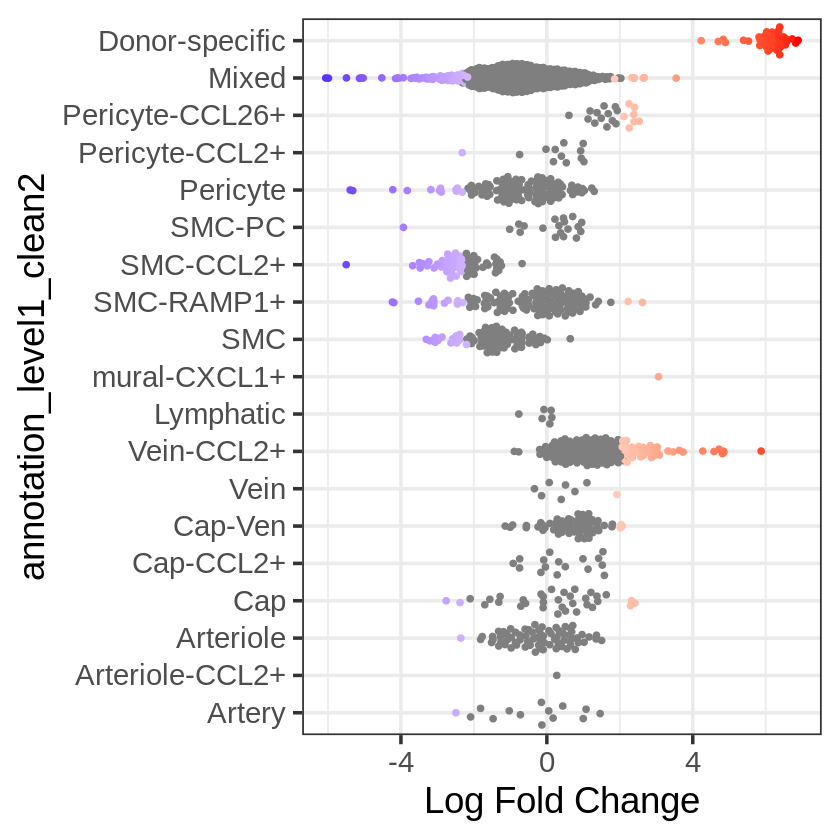

In [57]:
difab_plot_rm = plotDAbeeswarm(da_results2_clean1,  
                            group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red"))
difab_plot_rm
ggsave(filename = paste0(figures_path, "human_SKM_v2_EnSMC_moli_v3_r_Donorfilt.pdf"), plot = difab_plot_rm, width = 6, height = 5)

difab_plot_all = plotDAbeeswarm(da_results2, group.by ="annotation_level1_clean2") +scale_color_gradient2(low = ("blue"), high = ("red")) 
difab_plot_all
ggsave(filename = paste0(figures_path, "human_SKM_v2_EnSMC_moli_v3_r_all.pdf"), plot = difab_plot_all, width = 6, height = 5)

Change LogFC to 0 for Donor-specific and Mixed neighbourhoods (won't be displayed on umap)

In [58]:
da_results2$logFC2 = ifelse(da_results2$annotation_level1_clean2 %in% c('Mixed', 'Donor-specific'), 0, da_results2$logFC)

In [59]:
milo_obj = buildNhoodGraph(milo_obj)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



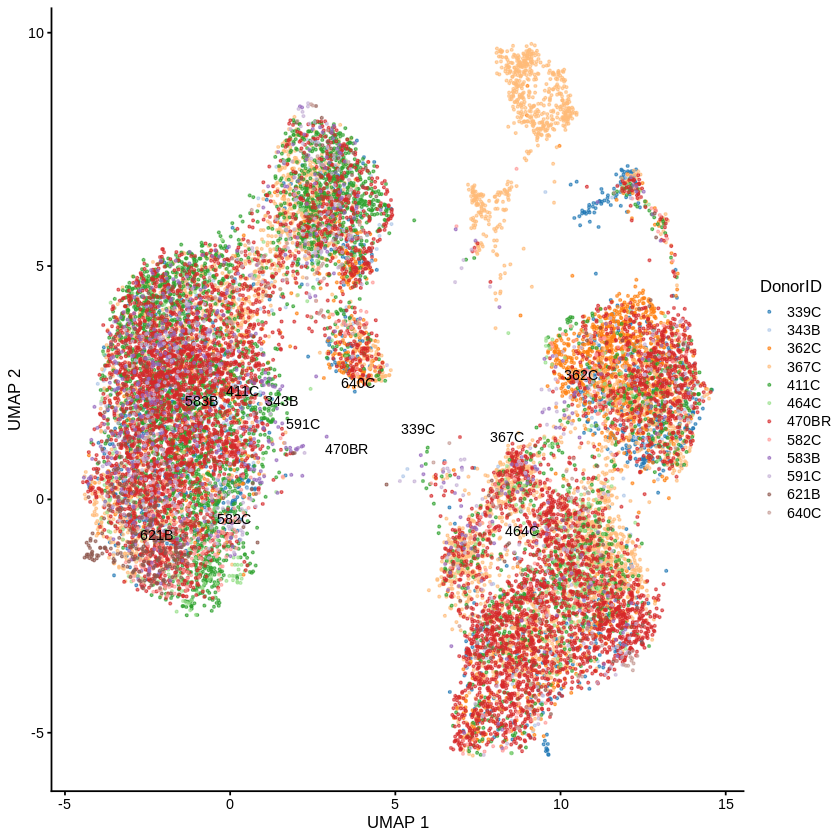

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



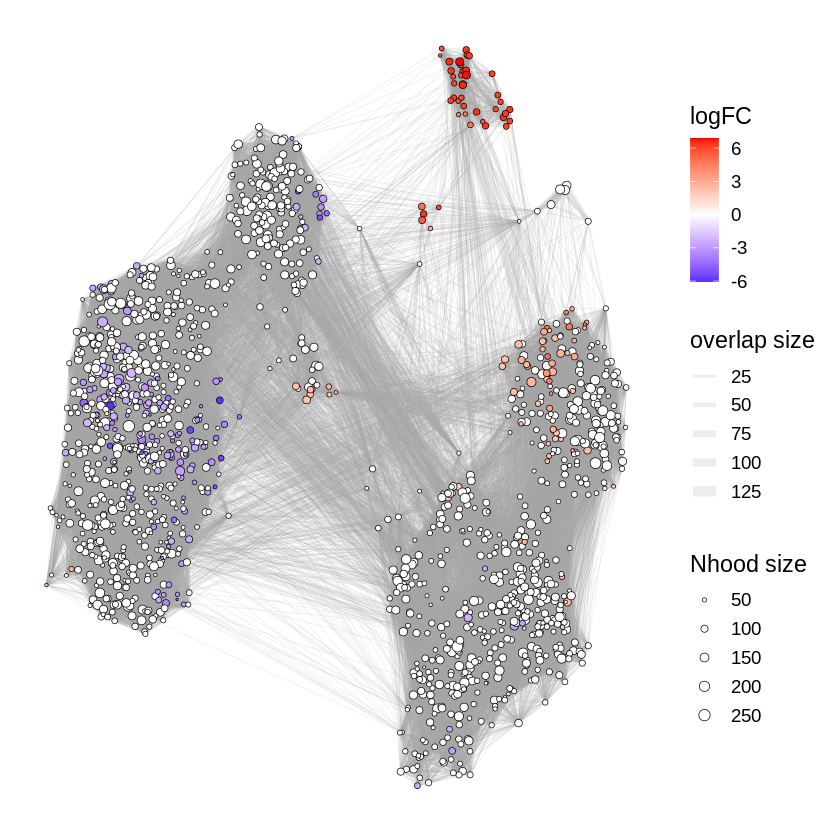

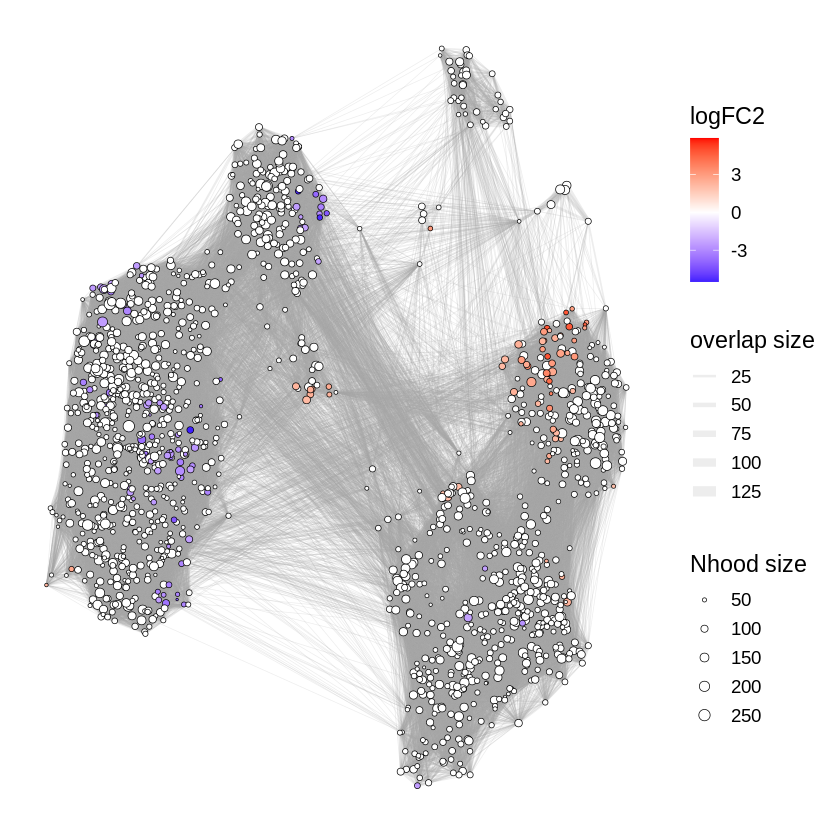

In [60]:
umap_pl <- plotReducedDim(milo_obj, dimred = "UMAP", colour_by="DonorID", 
                           text_by = "DonorID",text_size = 3, point_size=0.5) +
  guides(fill="none")
umap_pl

ggsave(paste0(figures_path, "human_SKM_v2_EnSMC_moli_v3_rdonor.pdf"), umap_pl, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are kept in)
nh_graph_pl1 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1) + 
scale_fill_gradient2(name = "logFC", low = ("blue"), high = ("red")) 
nh_graph_pl1
ggsave(paste0(figures_path, "human_SKM_v2_EnSMC_moli_v3_r_nhds.pdf"), nh_graph_pl1, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_EnSMC_moli_v3_r_nhds.png"), nh_graph_pl1, width = 4, height = 3.5)
## plot neighbourhood graph highlighting nhds with significant chnages 
## (Donor-specific and mixed populations are removed)
nh_graph_pl2 <- plotNhoodGraphDA(milo_obj, da_results2, layout="UMAP",alpha=0.1, res_column = "logFC2") + 
scale_fill_gradient2(name = "logFC2", low = ("blue"), high = ("red"))

nh_graph_pl2
ggsave(paste0(figures_path, "human_SKM_v2_EnSMC_moli_v3_r_nhds_filt.pdf"), nh_graph_pl2, width = 4, height = 3.5)
ggsave(paste0(figures_path, "human_SKM_v2_EnSMC_moli_v3_r_nhds_filt.png"), nh_graph_pl2, width = 4, height = 3.5)
#nh_plt_comb = umap_pl + nh_graph_pl1 +nh_graph_pl2
#  plot_layout(guides="collect")

In [61]:
fwrite(da_results2, file = paste0(tables_path,"human_SKM_v2_EnSMC_moli_v3_r_all.csv"))